# How-to estimate parameters using the smoothers ES and IES

**Note about notation**

The implementation of ES is based on section 9.5 of evensen2009, while the implementation of IES is based on evensen2019.
The notation used in the two papers differ slightly, so we have made a few tweaks to make them more similar.

- $A$ is used for the prior ensemble. (It's $X$ in evensen2019)
- $E$ is not divided by $\sqrt{N-1}$ as is done in evensen2019, which means that we do not multiply $E$ by $\sqrt{N-1}$ in the definition of $E$.
- We do not use $EE^T / (N-1)$ to estimate the parameter covariance matrix, because we assume a diagonal observation error covariance matrix $C_{dd}$.
We instead scale matrices used in the analysis step such that $C_{dd}$ becomes the identity matrix.
This is what is known as exact inversion.
- $Y$ is used to hold measured responses, which are predictions made by the dynamical model at points in time and space for which we have observations.

In [1]:
%load_ext autoreload

import numpy as np

np.set_printoptions(suppress=True)
rng = np.random.default_rng()

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 12})
from ipywidgets import interact
import ipywidgets as widgets

from p_tqdm import p_map

%autoreload 2
from dass import pde, utils, analysis, taper

## Define parameters, set true initial conditions and calculate the true temperature field

In [2]:
# Number of grid-cells in x and y direction
nx = 50

k_start = 0
k_end = 1000

dx = 1

# Set the coefficient of heat transfer for each grid cell.
alpha_t = np.ones((nx, nx)) * 8.25
# alpha_t[:, nx // 2 :] = 10.0

# Calculate maximum `dt`.
# If higher values are used, the numerical solution will become unstable.
# Choose `alpha` used here based on the maximum `alpha` that will be used in prior.
dt = dx**2 / (4 * 10.0)

# True initial temperature field.
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0
u = np.empty((k_end, nx, nx))
u.fill(0.0)
# Set the boundary conditions
u[:, (nx - 1) :, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (nx - 1) :] = u_right

# How much noise to add to heat equation.
scale = 0.1

u = pde.heat_equation(u, alpha_t, dx, dt, k_start, k_end, rng=rng, scale=scale)

# How-to create animation (Press `y` to convert from markdown to code)

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
p = ax.pcolormesh(u[0], cmap=plt.cm.jet, vmin=-150, vmax=150)
fig.colorbar(p)

def animate(k):
    return p.set_array(u[k])

anim = animation.FuncAnimation(
    fig, animate, interval=1, frames=k_end, repeat=False
)
anim.save("heat_equation_solution.gif", writer="imagemagick")

## Interactive plot of true temperature field

In [3]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True temperature field")
    p = ax.pcolormesh(u[k], vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_truth(k)>

## Define placement of sensors and generate synthetic observations based on the true temperature field

Number of observations:  50


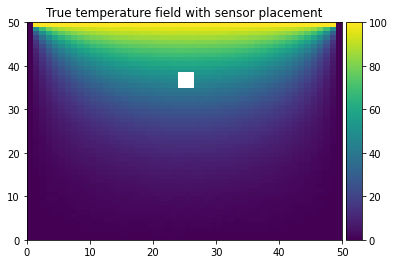

In [4]:
# placement of sensors, i.e, where the observations are done
#padding = int(0.15 * nx)
#x = np.linspace(padding, nx - padding, 3, dtype=int)
#y = np.linspace(padding, nx - padding, 3, dtype=int)
#obs_coordinates = [utils.Coordinate(xc, yc) for xc in x for yc in y]

obs_coordinates = [utils.Coordinate(nx // 2, nx // 2 + nx // 4)]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 50, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u)
# number of measurements
m = d.shape[0]
print("Number of observations: ", m)

# Plot temperature field and show placement of sensors.
obs_coordinates = set(zip(d.index.get_level_values("x"), d.index.get_level_values("y")))
x, y = zip(*obs_coordinates)

fig, ax = plt.subplots()
p = ax.pcolormesh(u[-1], cmap=plt.cm.viridis, vmin=0, vmax=100)
ax.set_title("True temperature field with sensor placement")
utils.colorbar(p)
ax.plot(x, y, "s", color="white", markersize=15)

# Ensemble Smoother (ES) and Iterative Ensemble Smoother (IES)

In [5]:
# Number of realisations
N = 100

## Define random seeds because multiprocessing

https://numpy.org/doc/stable/reference/random/parallel.html#seedsequence-spawning

In [6]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

## Define parameters to run different realisations with, aka the prior

In [7]:
# List of matrices of size (nx, nx) containing priors.
# The reason for having a list is that `p_map` requires it.
# `p_map` runs stuff in parallel.
alphas = []
for i in range(N):
    alpha = np.ones(shape=(nx, nx)) * rng.uniform(low=0.1, high=10.0)
    alphas.append(alpha)

# Evensens' formulation of the Ensemble Smoother has the prior as
# an (nx * nx, N) matrix, i.ie (number of parameters, N).
A = np.zeros(shape=(nx * nx, N))
for e in range(N):
    A[:, e] = alphas[e].ravel()    

## Run forward model (heat equation) `N` times

In [ ]:
fwd_runs = p_map(
    pde.heat_equation,
    [u] * N,
    alphas,
    [dx] * N,
    [dt] * N,
    [k_start] * N,
    [k_end] * N,
    streams,
    [scale] * N,
    desc=f"Running forward model.",
)

Running forward model.:   0%|          | 0/100 [00:00<?, ?it/s]

## Interactive plot of single realisations

In [ ]:
def interactive_realisations(k, n):
    fig, ax = plt.subplots()
    fig.suptitle(f"Temperature field for realisation {n}")
    p = ax.pcolormesh(fwd_runs[n][k], vmin=0, vmax=100)
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_realisations,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
    n=widgets.IntSlider(min=0, max=N - 1, step=1, value=0),
)

## Ensemble representation for measurements (Section 9.4 of evensen2009)

Note that Evensen calls measurements what ERT calls observations.

In [ ]:
# Assume diagonal ensemble covariance matrix for the measurement perturbations.
# NB! Big assumption.
Cdd = np.diag(d.sd.values**2)

# 9.4 Ensemble representation for measurements
E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
E = E - E.mean(axis=1, keepdims=True)
assert E.shape == (m, N)

# We will not use the sample covariance Cee, and instead use Cdd directly.
# It is not clear to us why Cee is proposed used.
# Cee = (E @ E.T) / (N - 1)

D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

## Measure model response at points in time and space where we have observations

In [ ]:
Y = np.array(
    [
        fwd_run[
            d.index.get_level_values("k").to_list(),
            d.index.get_level_values("y").to_list(),
            d.index.get_level_values("x").to_list(),
        ]
        for fwd_run in fwd_runs
    ]
).T

assert Y.shape == (
    m,
    N,
), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

## Perform ES update

In [ ]:
X = analysis.ES(Y, D, Cdd)
A_ES = A @ X

## Compare prior and posterior of ES

In [ ]:
A.mean(axis=1).mean()

In [ ]:
A_ES.mean(axis=1).mean()

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].hist(A[0])
# axes[1].hist(A[1])
# fig.suptitle("Prior")

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2)
# axes[0].hist(A_ES[0])
# axes[1].hist(A_ES[1])
# fig.suptitle("Posterior")

# IES

In [ ]:
# Step length in Gauss Newton
gamma = 1.0

# Line 2 of `Algorithm 1`.

# Coefficient matrix as defined in Eq. 16 and Eq. 17.
W = np.zeros(shape=(N, N))

# Equivalent to X1 = X.
Xs = [A]

## Check that single iteration of IES with step length 1.0 is the same as ES.

In [ ]:
W = analysis.IES(Y, D, Cdd, W, gamma)
X_IES = np.identity(N) + W
A_IES = A @ X_IES
assert np.isclose(A_IES, A_ES).all()